In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

In [2]:
data_high_freq=pd.read_csv("id_with_1ormore_freq.csv",on_bad_lines="skip")
data_low_freq=pd.read_csv("id_with_0_freq.csv",on_bad_lines="skip")

In [3]:
#reduce the error
data_high_freq.head(10)
data_high_freq=data_high_freq[data_high_freq['RECHARGE_AMOUNT']!=0].reset_index()

In [4]:
data_high_freq['RATIO']=data_high_freq['TOTAL_DSTR']/data_high_freq['RECHARGE_AMOUNT']

Text(0.5, 1.0, 'Recharge Amount vs. Total Revenue')

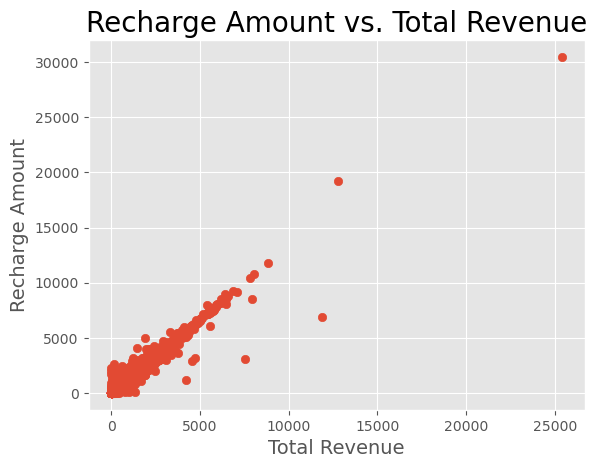

In [5]:
ax=plt.scatter(data_high_freq['TOTAL_DSTR'],data_high_freq['RECHARGE_AMOUNT'])
plt.xlabel('Total Revenue',fontsize=14)
plt.ylabel('Recharge Amount',fontsize=14)
plt.title('Recharge Amount vs. Total Revenue',fontsize=20)                                                        

In [6]:
data_high_freq['RATIO'].describe()


count    81609.000000
mean         0.758358
std          0.191436
min          0.000000
25%          0.733654
50%          0.750478
75%          0.769799
max         23.063000
Name: RATIO, dtype: float64

In [7]:
# handle outliers 
data_high_freq=data_high_freq[data_high_freq['RATIO']<3].reset_index()

In [8]:
#Convert categorical factors to numerical factors
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data_high_freq['PRODUCT_TYPE']=data_high_freq['PRODUCT_TYPE'].apply(lambda x: 1 if x =='PRP' else 0)
data_high_freq[['PRICE_PLAN','HS_CONN','HS_TYPE','PRODUCT_TYPE']]=data_high_freq[['PRICE_PLAN','HS_CONN','HS_TYPE','PRODUCT_TYPE']].apply(le.fit_transform)

In [9]:
#delete columns not using in analysis
data_high_freq.drop(['REGION','RG','MSISDN'],axis=1)

for i in range(len(data_high_freq)):
    if data_high_freq['RATIO'][i]<0.7:
        data_high_freq['RATIO'][i]= 0
    else:
        data_high_freq['RATIO'][i]= 1
# filter data
data_high_freq_k = data_high_freq[["TOTAL_DSTR","VOICEREV_TOTAL","DATAREV_TOTAL","SMSREV_TOTAL",
                                 "RG_DAYS",'PRICE_PLAN','HS_CONN','HS_TYPE','VOL_KB', 'MO_MOU','RATIO']]

C:\Users\zhuhe\AppData\Local\Temp\ipykernel_41140\4183622778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_freq['RATIO'][i]= 1
C:\Users\zhuhe\AppData\Local\Temp\ipykernel_41140\4183622778.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_freq['RATIO'][i]= 0


In [10]:
data_high_freq_k.columns.tolist()

['TOTAL_DSTR',
 'VOICEREV_TOTAL',
 'DATAREV_TOTAL',
 'SMSREV_TOTAL',
 'RG_DAYS',
 'PRICE_PLAN',
 'HS_CONN',
 'HS_TYPE',
 'VOL_KB',
 'MO_MOU',
 'RATIO']

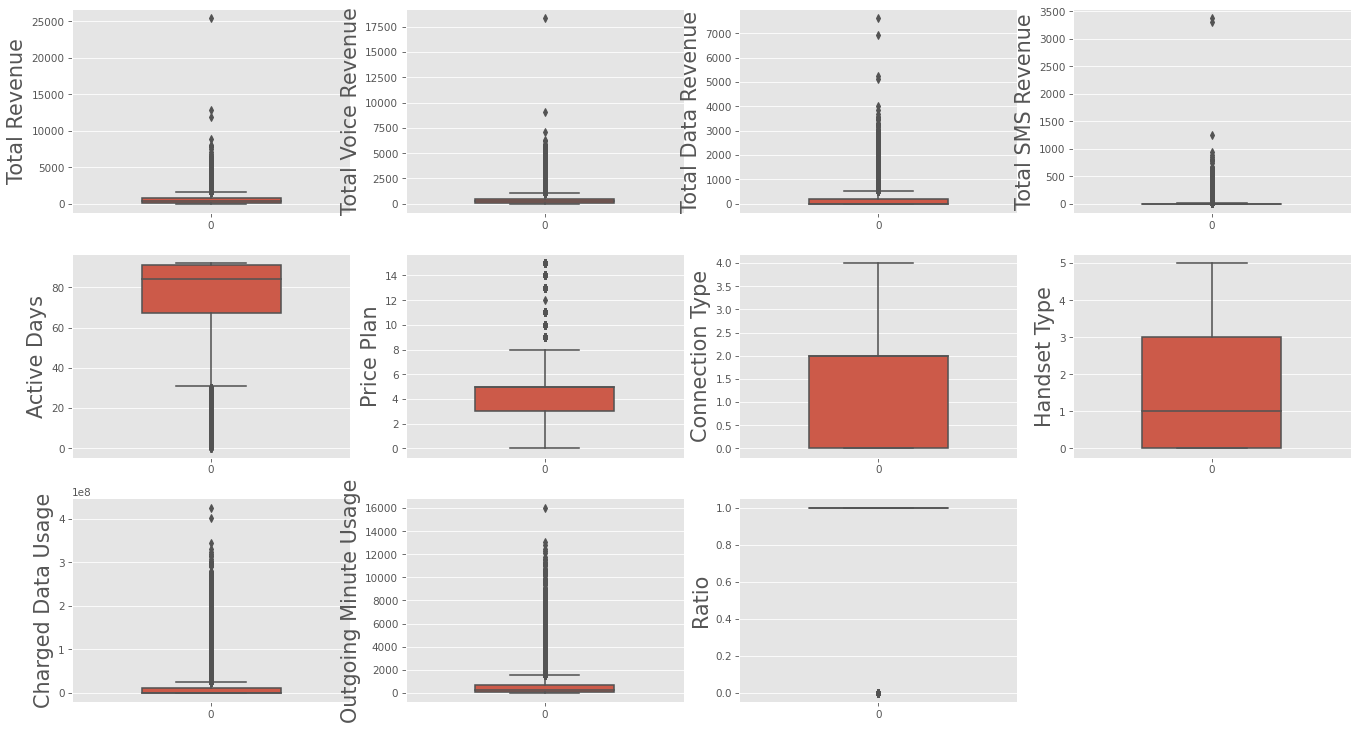

In [11]:
#stand data 
#high ratio
c = ['Total Revenue','Total Voice Revenue','Total Data Revenue','Total SMS Revenue','Active Days','Price Plan','Connection Type','Handset Type', 
     'Charged Data Usage', 'Outgoing Minute Usage','Ratio']
column = data_high_freq_k.columns.tolist() 
fig = plt.figure(figsize=(22, 12), dpi=75)  
for i in range(11):
    plt.subplot(3,4, i + 1)  
    sns.boxplot(data=data_high_freq_k[column[i]], orient="v",width=0.5) 
    plt.ylabel(c[i], fontsize=20)
plt.show()

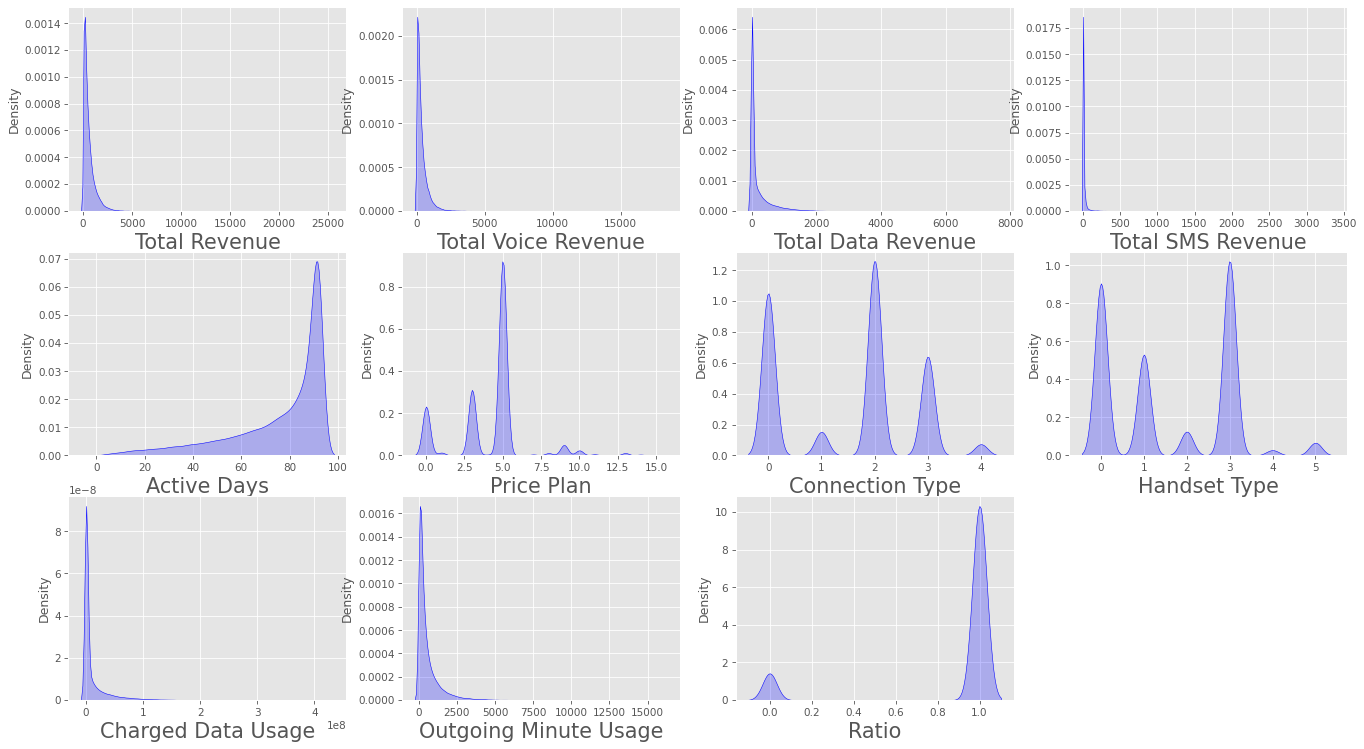

In [12]:
c=['Total Revenue','Total Voice Revenue','Total Data Revenue','Total SMS Revenue','Active Days','Price Plan','Connection Type','Handset Type',
  'Charged Data Usage', 'Outgoing Minute Usage','Ratio'] # column names
column = data_high_freq_k.columns.tolist() 
fig = plt.figure(figsize=(22, 12), dpi=75)  
for i in range(11):
    plt.subplot(3,4, i + 1) 
    ax = sns.kdeplot(data=data_high_freq_k[column[i]],color='blue',shade= True)
    plt.xlabel(c[i], fontsize=20)
    #plt.ylabel(column[i], fontsize=20)
plt.show()


[897148.9999999999, 715904.1995063598, 610808.4783461149, 534656.0705489374, 466122.1017799877, 432564.00636906864, 406094.4040892665, 376039.80967720016, 351576.7928982683, 329757.7326843621, 312155.9458841106]


Text(0.5, 1.0, 'K-means Clustering')

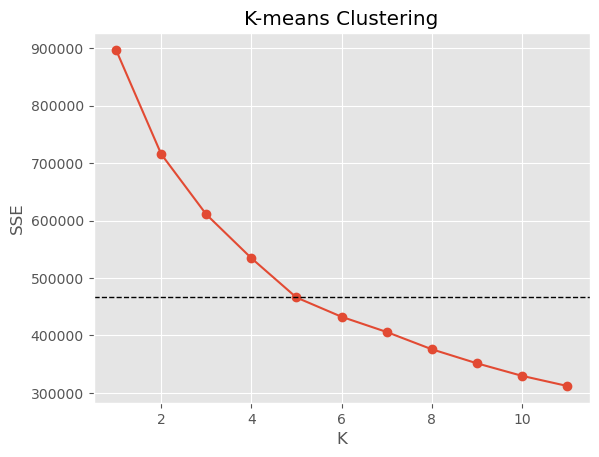

In [13]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_high_freq_k)
data_high_freq_stand = scaler.transform(data_high_freq_k)
# k-means clustering
from sklearn.cluster import KMeans
# find k
sse = []
for k in range(1,12):
    model = KMeans(n_clusters=k, random_state=123, n_init=20)
    model.fit(data_high_freq_stand)
    sse.append(model.inertia_)
print(sse)

plt.plot(range(1, 12), sse, 'o-')
plt.axhline(sse[4], color='k', linestyle='--', linewidth=1) # seems like k = 5
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('K-means Clustering')

In [14]:
#!pip install threadpoolctl==3.1.0

In [21]:
# model
kmeans_model = KMeans(n_clusters=5, random_state=123, n_init=20)
kmeans_model.fit(data_high_freq_stand)

kmeans_labels = kmeans_model.labels_   # labels
pd.Series(kmeans_labels).value_counts()
data_high_freq_k["kind"]=pd.Series(kmeans_labels)
#data_high_freq_k.head()
data_high_freq_k.groupby('kind').count()

C:\Users\zhuhe\AppData\Local\Temp\ipykernel_41140\2379121701.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_freq_k["kind"]=pd.Series(kmeans_labels)


,TOTAL_DSTR,VOICEREV_TOTAL,DATAREV_TOTAL,SMSREV_TOTAL,RG_DAYS,PRICE_PLAN,HS_CONN,HS_TYPE,VOL_KB,MO_MOU,RATIO
kind,,,,,,,,,,,
0,9690,9690,9690,9690,9690,9690,9690,9690,9690,9690,9690
1,22050,22050,22050,22050,22050,22050,22050,22050,22050,22050,22050
2,5236,5236,5236,5236,5236,5236,5236,5236,5236,5236,5236
3,7715,7715,7715,7715,7715,7715,7715,7715,7715,7715,7715
4,36868,36868,36868,36868,36868,36868,36868,36868,36868,36868,36868


In [22]:
#data_high_ratio.groupby('kind').describe()
data_high_freq_plot=pd.DataFrame(data_high_freq_stand,columns=data_high_freq_k.columns[:11])
data_high_freq_plot["kind"]=pd.Series(kmeans_labels)

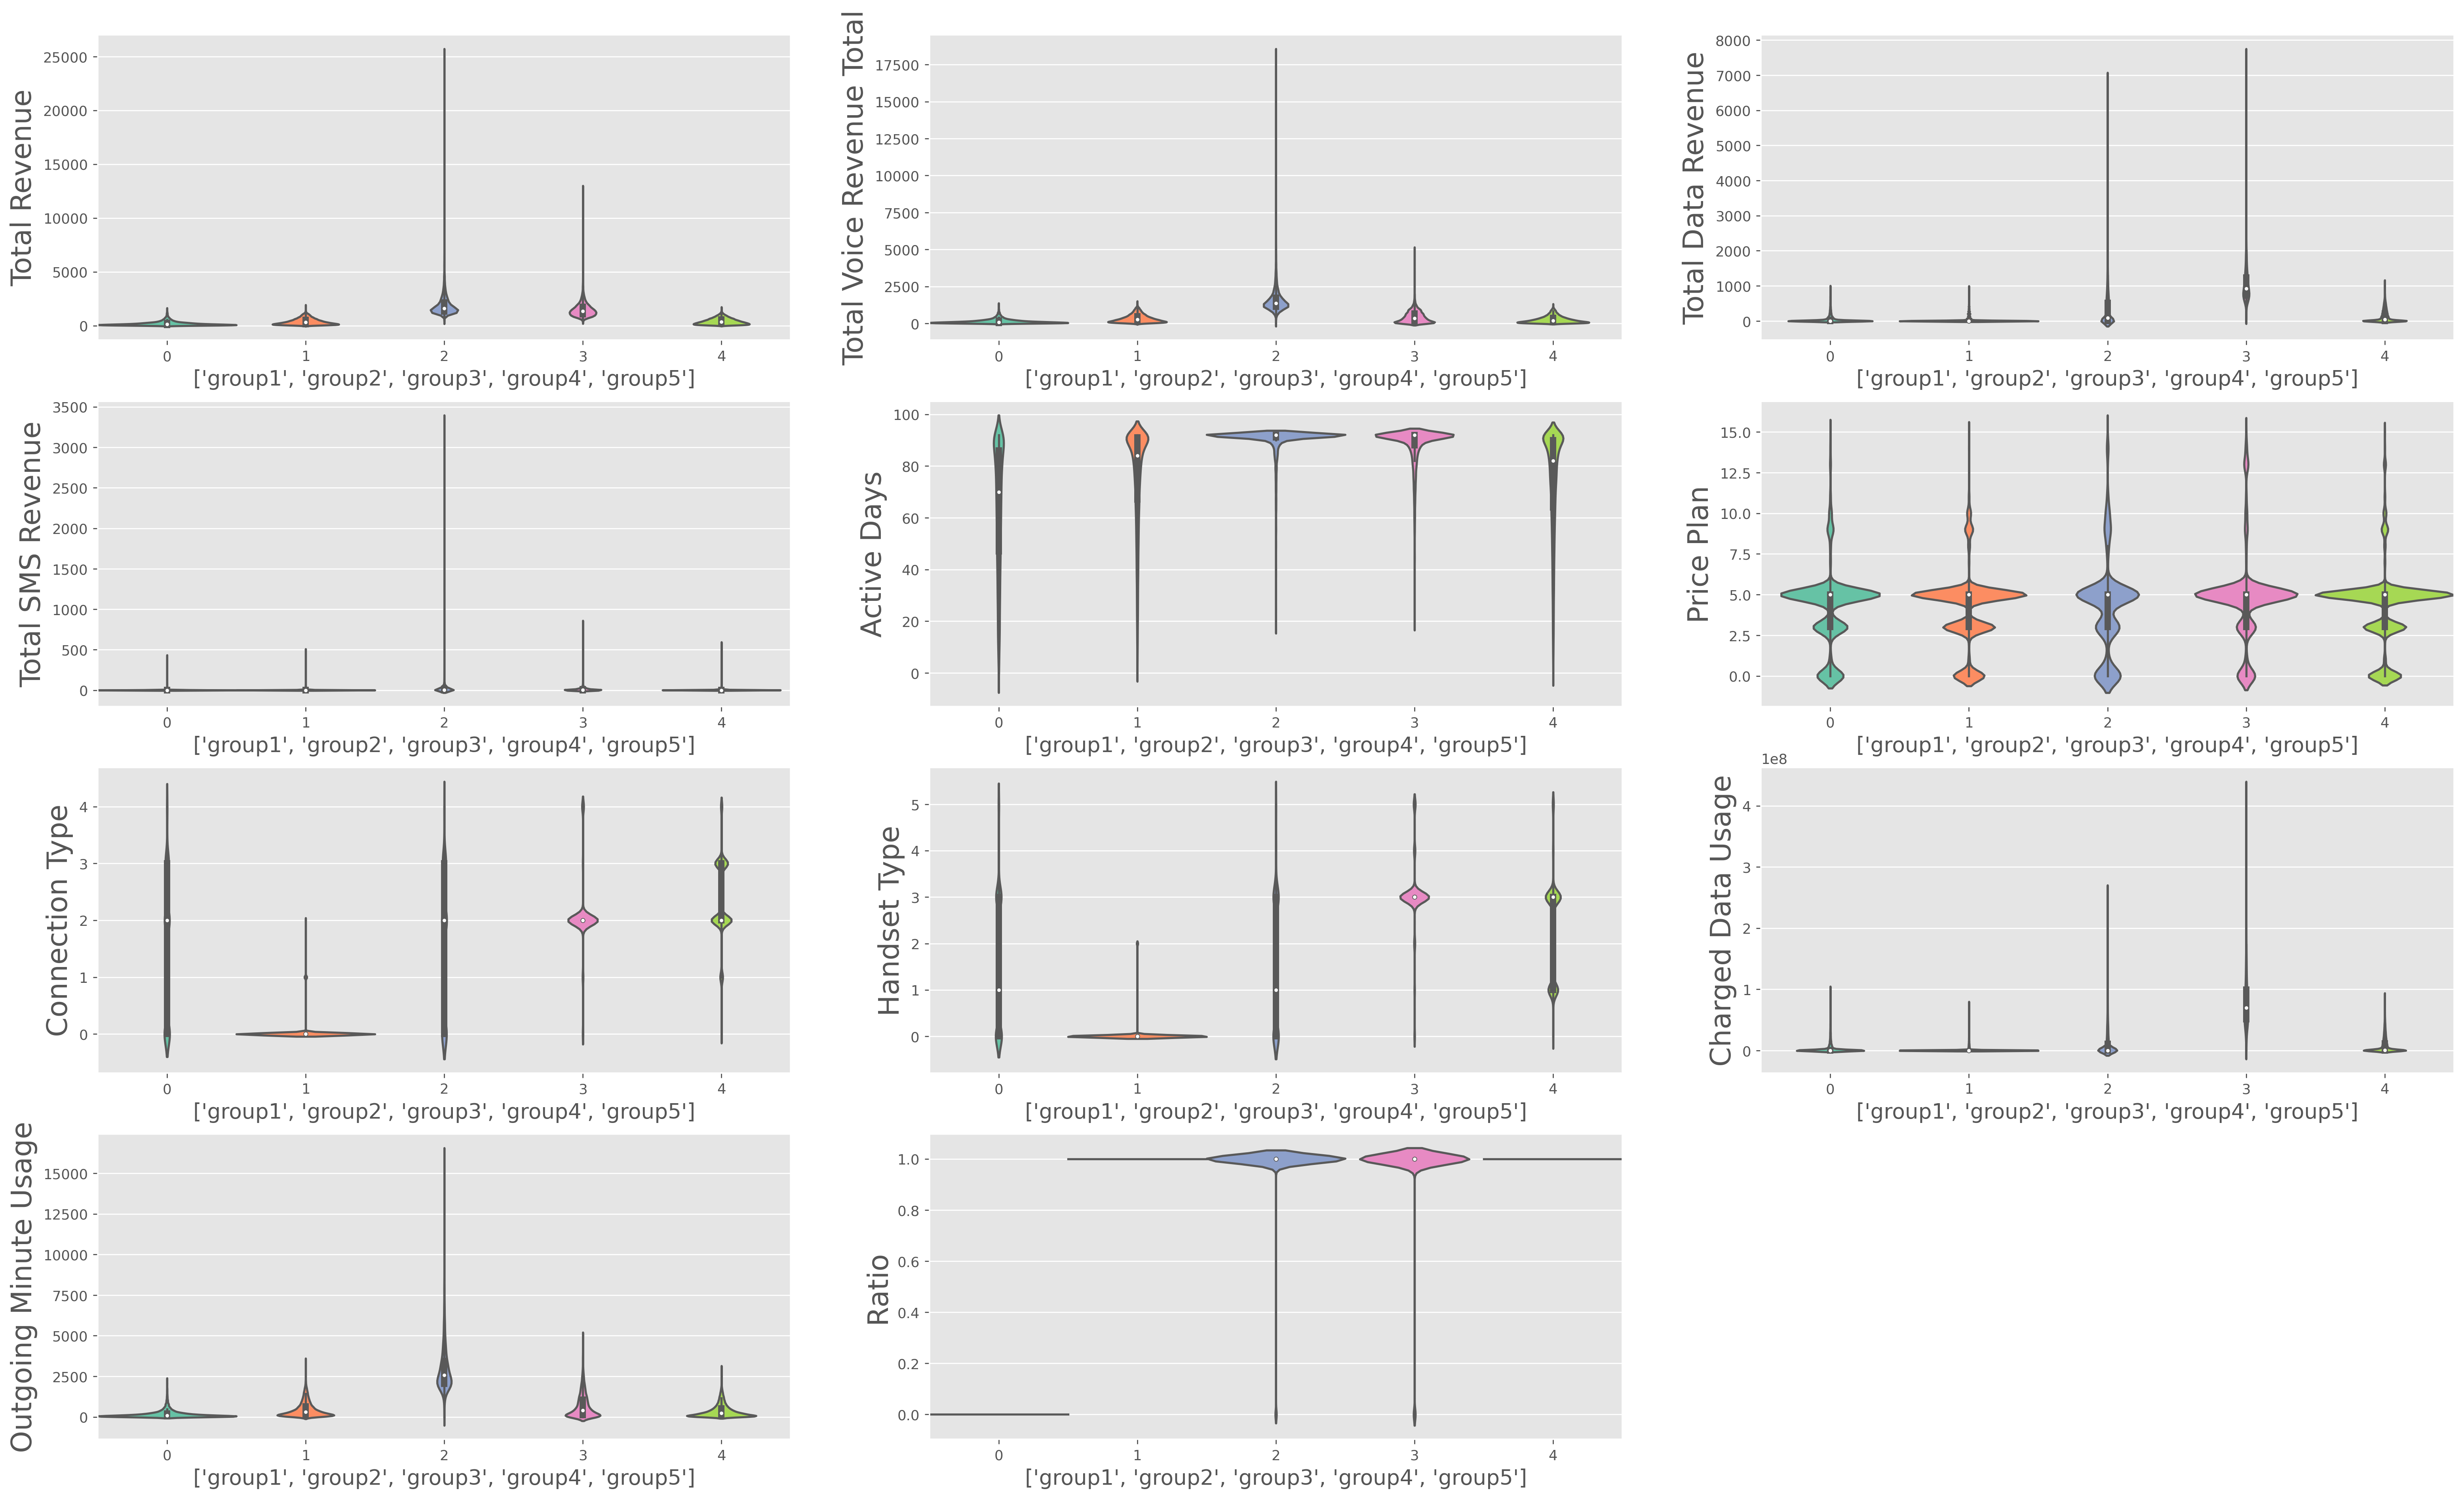

In [41]:
column = data_high_freq_k.columns.tolist()
c=['Total Revenue','Total Voice Revenue Total','Total Data Revenue','Total SMS Revenue','Active Days','Price Plan','Connection Type','Handset Type', 'Charged Data Usage', 'Outgoing Minute Usage','Ratio'] # 列表头
fig = plt.figure(figsize=(30, 18), dpi=256) 
 
for i in range(11):
    plt.subplot(4,3, i + 1)
    ax = sns.violinplot(x='kind',y=column[i],width=1,saturation=1,lw=1,palette="Set2",orient="v",inner="box", hspace = 2, data=data_high_freq_k)
    plt.xlabel((['group' + str(i+1) for i in range(5)]),fontsize=15)
    plt.ylabel(c[i], fontsize=20)
plt.show()


In [18]:

#https://blog.csdn.net/weixin_46277779/article/details/127065221

In [19]:
#['Total Revenue','Total Voice Revenue Total','Total Data Revenue','Total SMS Revenue','Active Days','Price Plan','Connection Type','Handset Type','Ratio']

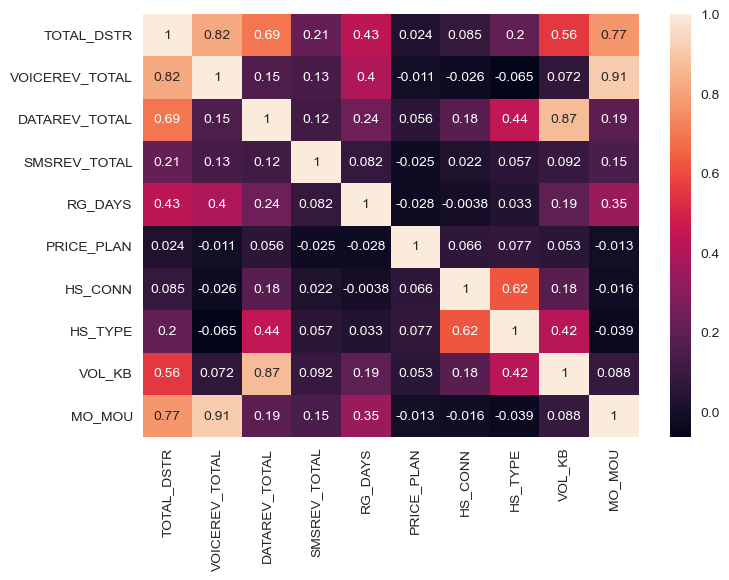

,Total Revenue,Total Voice Revenue Total,Total Data Revenue,Total SMS Revenue,Active Days,Price Plan,Connection Type,Handset Type,Charged Data Usage,Outgoing Minute Usage
"(3, Total Revenue)",1.000000,0.678659,0.756382,0.169362,0.260501,-0.036968,-0.045988,-0.032209,0.471714,0.520401
"(3, Total Voice Revenue Total)",0.678659,1.000000,0.049093,0.229037,0.218148,-0.082145,-0.068493,-0.056217,0.050544,0.854775
"(3, Total Data Revenue)",0.756382,0.049093,1.000000,-0.050233,0.162709,0.016709,0.000408,0.007017,0.612169,-0.040783
"(3, Total SMS Revenue)",0.169362,0.229037,-0.050233,1.000000,0.060973,-0.068369,-0.032615,-0.019420,-0.020816,0.219578
"(3, Active Days)",0.260501,0.218148,0.162709,0.060973,1.000000,-0.023310,-0.020737,0.023009,0.095160,0.187940
"(3, Price Plan)",-0.036968,-0.082145,0.016709,-0.068369,-0.023310,1.000000,0.311140,0.267963,0.022040,-0.060944
"(3, Connection Type)",-0.045988,-0.068493,0.000408,-0.032615,-0.020737,0.311140,1.000000,0.782246,0.057675,-0.040375
"(3, Handset Type)",-0.032209,-0.056217,0.007017,-0.019420,0.023009,0.267963,0.782246,1.000000,0.060714,-0.028527
"(3, Charged Data Usage)",0.471714,0.050544,0.612169,-0.020816,0.095160,0.022040,0.057675,0.060714,1.000000,0.074980
"(3, Outgoing Minute Usage)",0.520401,0.854775,-0.040783,0.219578,0.187940,-0.060944,-0.040375,-0.028527,0.074980,1.000000


In [174]:
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use("seaborn")

# X = data_high_freq_plot.drop(["kind",'RATIO'], axis= 1, inplace = False)
# #print(X)
# sns.heatmap(X.corr(), annot = True)
# plt.show()

x = data_high_freq_plot.drop(['RATIO', 'Handset'], axis= 1, inplace = False)
x = x.groupby("kind")
x.first(0)

c = ['Total Revenue','Total Voice Revenue Total','Total Data Revenue','Total SMS Revenue',
     'Active Days','Price Plan','Connection Type','Handset Type', 'Charged Data Usage', 'Outgoing Minute Usage'] 

x["kind"].value_counts()

x = x.corr(method = "pearson")
# x.rename(columns={'TOTAL_DSTR':'Total_revenue','VOICEREV_TOTAL':'Total_voice_rev','DATAREV_TOTAL':'Total_data_rev',
#                             'SMSREV_TOTAL':'Total_sms_rev', "RG_DAYS":"Active Days",
#                            'PRICE_PLAN':'Price_plan',"HS_CONN":"Hand set connection type","HS_TYPE":"Hand set type"}, inplace = True)
x.columns = c


new_index = []

for i in range(10):
    new_index.append((0,c[i]))
for i in range(10):
    new_index.append((1,c[i]))
for i in range(10):
    new_index.append((2,c[i]))
for i in range(10):
    new_index.append((3,c[i]))
for i in range(10):
    new_index.append((4,c[i]))
x.index = new_index

x_3 = x.iloc[30:40]   # Selects alternate rows
x_3

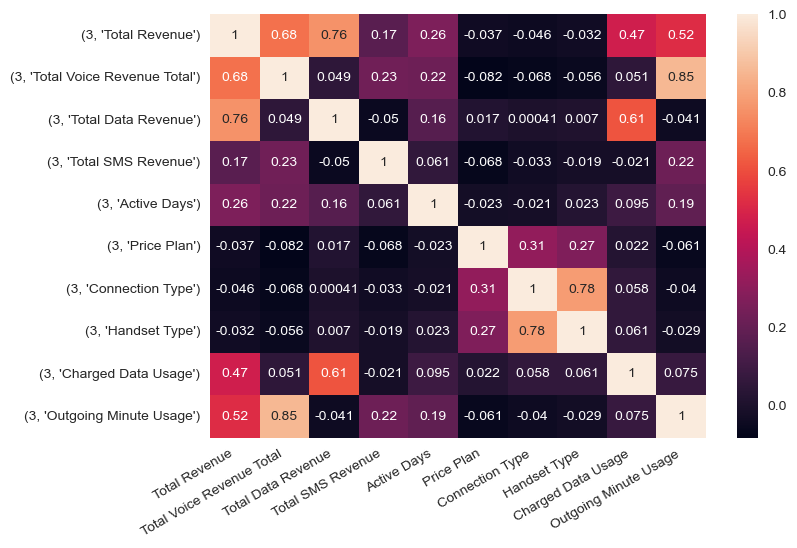

In [176]:
sns.heatmap(x_3, annot = True)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)
plt.xticks(rotation=30, ha='right')
plt.show()